In [2]:
# !pip install -q sentence-transformers

In [1]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-mpnet-base-v2')

/opt/anaconda3/envs/ai-playground/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
sentences = [
    "it caught him off guard that space smelled of seared steak",
    "she could not decide between painting her teeth or brushing her nails",
    "he thought there'd be sufficient time is he hid his watch",
    "the bees decided to have a mutiny against their queen",
    "the sign said there was road work ahead so she decided to speed up",
    "on a scale of one to ten, what's your favorite flavor of color?",
    "flying stinging insects rebelled in opposition to the matriarch"
]

In [3]:
embeddings = model.encode(sentences)
embeddings.shape

(7, 768)

In [4]:
# Compute cosine similarity between the first and other sentence in sentences
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity([embeddings[0]], embeddings[1:])
# Print the similarity scores
for i, score in enumerate(similarity[0]):
    print(f"Similarity between sentence 0 and sentence {i + 1}: {score:.4f}")

Similarity between sentence 0 and sentence 1: 0.1293
Similarity between sentence 0 and sentence 2: 0.3083
Similarity between sentence 0 and sentence 3: 0.1389
Similarity between sentence 0 and sentence 4: 0.1416
Similarity between sentence 0 and sentence 5: 0.0970
Similarity between sentence 0 and sentence 6: 0.1232


## Fast DPR setup

In [5]:
from transformers import DPRContextEncoder, DPRContextEncoderTokenizer, \
                         DPRQuestionEncoder, DPRQuestionEncoderTokenizer

ctx_model = DPRContextEncoder.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')
ctx_tokenizer = DPRContextEncoderTokenizer.from_pretrained('facebook/dpr-ctx_encoder-single-nq-base')

question_model = DPRQuestionEncoder.from_pretrained('facebook/dpr-question_encoder-single-nq-base')
question_tokenizer = DPRQuestionEncoderTokenizer.from_pretrained('facebook/dpr-question_encoder-single-nq-base')

Some weights of the model checkpoint at facebook/dpr-ctx_encoder-single-nq-base were not used when initializing DPRContextEncoder: ['ctx_encoder.bert_model.pooler.dense.bias', 'ctx_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRContextEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRContextEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DPRQuestionEncoderTokenizer'. 
The class this function is called from is 'DPRContextEncoderTokeniz

In [6]:
questions = [
    "what is the capital city of australia?",
    "what is the best selling sci-fi book?",
    "how many searches are performed on Google?"
]

contexts = [
    "canberra is the capital city of australia",
    "what is the capital city of australia?",
    "the capital city of france is paris",
    "what is the best selling sci-fi book?",
    "sc-fi is a popular book genre read by millions",
    "the best-selling sci-fi book is dune",
    "how many searches are performed on Google?",
    "Google serves more than 2 trillion queries annually",
    "Google is a popular search engine"
]

In [7]:
xb_tokens = ctx_tokenizer(contexts, max_length=256, padding='max_length',
                          truncation=True, return_tensors='pt')
xb = ctx_model(**xb_tokens)

xq_tokens = question_tokenizer(questions, max_length=256, padding='max_length',
                               truncation=True, return_tensors='pt')
xq = question_model(**xq_tokens)

In [8]:
xb

DPRContextEncoderOutput(pooler_output=tensor([[ 0.2306, -0.1571,  0.3745,  ..., -0.3221,  0.3048,  0.0551],
        [ 0.4064,  0.2081,  0.0089,  ..., -0.3295,  0.3807,  0.1702],
        [ 0.0656, -0.3728,  0.1148,  ..., -0.5293,  0.7368,  0.1970],
        ...,
        [ 0.4523,  0.2389,  0.3630,  ..., -0.4599,  0.4441,  0.5663],
        [ 0.1803,  0.5517,  0.3165,  ..., -0.1818,  0.5420,  0.4134],
        [ 0.3179,  0.1512,  0.3724,  ..., -0.4222,  0.5759,  0.6114]],
       grad_fn=<SliceBackward0>), hidden_states=None, attentions=None)

In [9]:
xb.pooler_output.shape, xq.pooler_output.shape

(torch.Size([9, 768]), torch.Size([3, 768]))

In [11]:
# Let's check the answer with most similarity to each question in xq

import torch
from sentence_transformers import util

for i, xq_vec in enumerate(xq.pooler_output):
    probs = util.cos_sim(xq_vec, xb.pooler_output)
    argmax = torch.argmax(probs)
    print(questions[i])
    print(contexts[argmax])
    print('---')

what is the capital city of australia?
canberra is the capital city of australia
---
what is the best selling sci-fi book?
the best-selling sci-fi book is dune
---
how many searches are performed on Google?
how many searches are performed on Google?
---


## Image text embeddings

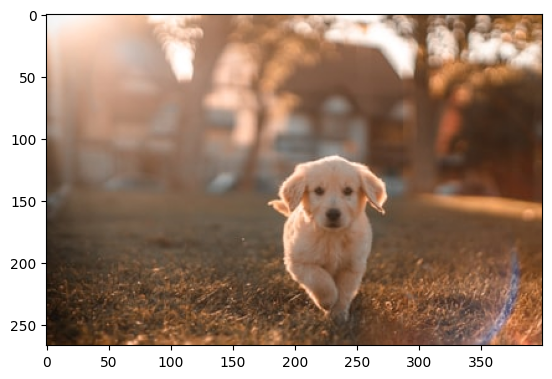

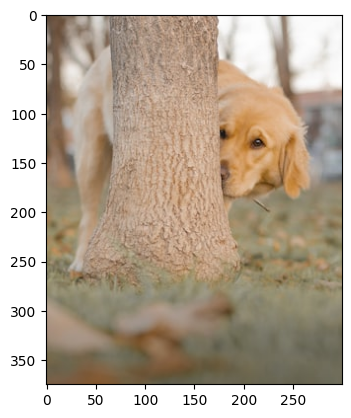

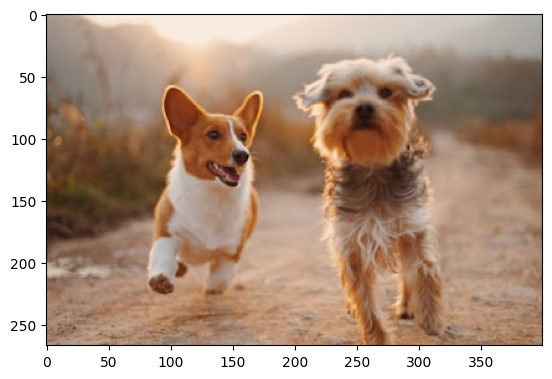

In [13]:
from PIL import Image
import requests

import matplotlib.pyplot as plt
import numpy as np

urls = [
    "https://images.unsplash.com/photo-1576201836106-db1758fd1c97?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80",
    "https://images.unsplash.com/photo-1591294100785-81d39c061468?ixlib=rb-1.2.1&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=300&q=80",
    "https://images.unsplash.com/photo-1548199973-03cce0bbc87b?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=400&q=80"
]

images = [
    Image.open(requests.get(url, stream=True).raw) for url in urls]

# let's see what we have
for image in images:
    plt.show(plt.imshow(np.asarray(image)))